# EDF to sqlite converter
This notebook takes the .edf files placed in data/files and bundles them together to a sqlite database.
Each row in the database has similar attributes(frequency length, attribute mapping). The final database can be used as a data source using the SqliDataSet (this converts the resulting tensors into the correct shape for processing)

The current dataset in use is gathered from [https://www.physionet.org/content/eegmmidb/1.0.0/](https://www.physionet.org/content/eegmmidb/1.0.0/)

In [16]:
import matplotlib.pyplot as plt
import pyedflib as edf
import numpy as np
import numpy.typing as npt
import sqlite3 as sql
from fastai.data.all import get_files
from tqdm import tqdm
import sql_data_manager as sql
import error_tracker
from importlib import reload
reload(error_tracker)
reload(sql)


<module 'sql_data_manager' from 'c:\\Users\\fredf\\git\\DAT255\\Imaginary-movement\\sql_data_manager.py'>

## Current work done

([<matplotlib.patches.Wedge at 0x2171b751d90>,
 [Text(0.5299290306818474, 0.9639373540021144, 'where to find data?'),
  Text(-0.5599456069679141, -0.9468162003458402, 'data preprocessing'),
  Text(1.0994572119784658, -0.03455197575449488, 'machine learning')])

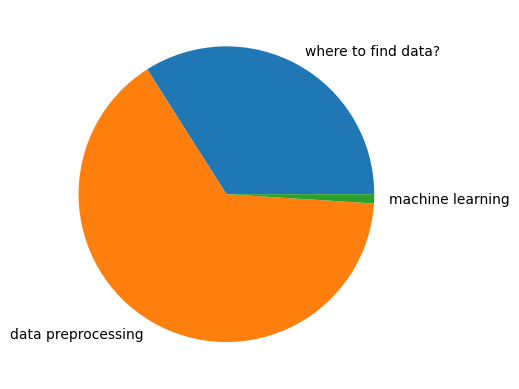

In [2]:
plt.pie([34, 65, 1], labels=["where to find data?", "data preprocessing", "machine learning"])

## Helper exception
Used during processing to track what errors have occured.

In [3]:
class EdfException(BaseException):
    """Exception thrown due to errors in the edf files.
    """
    def __init__(self, error_kind: str, error_message: str) -> None:
        """Constructs a new EdfException with the provided kind and message

        Parameters
        ----------
        error_kind: str, required
            What kind of edf exception occured. This is used later to aggregate the errors in the data set.
        
        error_message: str, required
            the error message. this is what's displayed if the message is printed.
        """
        self.error_kind = error_kind
        super().__init__(error_message)

## time range correction
The .edf format

In [4]:
def correct_time_ranges(time_start: npt.NDArray[np.floating], time_range: npt.NDArray[np.floating]) -> npt.NDArray[np.floating]:
    """Mutates the `time_start` parameter so that `time_start[x] + time_range[x] == time_start[x+1]`.

    This method will only change the time_start value on index `x` if x is equal to `time_start[x-1] + time_range[x-1]` rounded of to 1 or 2 decimals.
    Otherwise the value will be left unchanged.
    
    Parameters
    ----------
    time_start: `np.ndarray[float]`, required
        the start of each timespan.
        This value is mutated
    
    time_range: `np.ndarray[float]`, required
        the length of each timespan.

    Returns
    -------
    `np.ndarray[float]`
        The original array provided in `time_start`
    """

    for start, s_range, val in zip(np.nditer(time_start[:-1], op_flags=['readonly']), np.nditer(time_range[:-1], op_flags=['readonly']), np.nditer(time_start[1:], op_flags=['readwrite'])):
        if start + s_range == val:
            continue

        expected = start + s_range
        if np.round(expected, 2) == val:
            val[...] = expected
            #print("found rounding of 2", expected)
        elif np.round(expected, 1) == val:
            val[...] = expected
            #print("found rounding of 1", expected)
        else:    
            raise EdfException("invalid time range", f"start time and accumulated time does not match: {start}, {s_range}, ({expected}), {val}") 
    
    return time_start

In [5]:
def resample_time_range(frequencies: npt.NDArray[np.floating], labels: npt.NDArray[np.uint8], original_freq: float):
    try:
        target_freq = 160.0
        time = frequencies.shape[1]/original_freq
        #print(frequencies.shape[1], time)
        freq_indices = np.arange(0,time, 1.0/original_freq)
        interp_indices = np.arange(0, time, 1.0/target_freq)
        #print(freq_indices, interp_indices)

        out_f = np.zeros((frequencies.shape[0], interp_indices.shape[0]))

        for i in range(frequencies.shape[0]):
            out_f[i,:] = np.interp(interp_indices, freq_indices, frequencies[i,:])
        
        out_f = out_f.round(0).astype(np.uint16)
        
        freq_indices = np.arange(frequencies.shape[1])
        interp_indices = (np.arange(out_f.shape[1]) / out_f.shape[1]) * frequencies.shape[1]

        out_l = np.interp(interp_indices, freq_indices, freq_indices).round(0).astype(np.int32)
        return (out_f, labels[out_l])
    except BaseException as e:
        raise EdfException("resampling error", e)


In [6]:
def read_file(file: str) -> tuple[float, npt.NDArray[np.floating], npt.NDArray[np.floating], npt.NDArray[np.floating], np.ndarray[np.object_], list[str]]:
    with edf.EdfReader(file) as file_reader:
        freqs = file_reader.getSampleFrequencies() 
        if not np.all(freqs == freqs[0]):
            raise EdfException("uneven sampling", f"uneven sampling in {file}")
        
        freq: float = freqs[0]

        time_start, time_range, labels = file_reader.readAnnotations()
        if len(time_start) > 1:
            time_start = correct_time_ranges(time_start, time_range)
        
        signal_labels = file_reader.getSignalLabels()

        num_signals = file_reader.signals_in_file
        signals = np.zeros((num_signals, file_reader.getNSamples()[0]))
        for i in range(num_signals):
            signals[i, :] = file_reader.readSignal(i)

        return (freq, signals, time_start, time_range, labels, signal_labels)

In [7]:
def get_run_id(file_name: str) -> int:
    """
    retrieves the run id from the file name.
    Expects the file name to be structured as S<candidate id>R<run id>.edf
    """
    start = file_name.rfind('R')+1
    end = file_name.rfind('.')
    return int(file_name[start:end])

In [8]:
REST_POSITION = 1

OPEN_CLOSE_LEFT_FIST_ACTUAL = 2
OPEN_CLOSE_LEFT_FIST_IMAGINED = 3
OPEN_CLOSE_RIGHT_FIST_ACTUAL = 4
OPEN_CLOSE_RIGHT_FIST_IMAGINED = 5
OPEN_CLOSE_BOTH_FISTS_ACTUAL = 6
OPEN_CLOSE_BOTH_FISTS_IMAGINED = 7
OPEN_CLOSE_BOTH_FEET_ACTUAL = 8
OPEN_CLOSE_BOTH_FEET_IMAGINED = 9

TASK_1 = {
    "T0": REST_POSITION,
    "T1": OPEN_CLOSE_LEFT_FIST_ACTUAL,
    "T2": OPEN_CLOSE_RIGHT_FIST_ACTUAL
}
TASK_2 = {
    "T0": REST_POSITION,
    "T1": OPEN_CLOSE_LEFT_FIST_IMAGINED,
    "T2": OPEN_CLOSE_RIGHT_FIST_IMAGINED
}
TASK_3 = {
    "T0": REST_POSITION,
    "T1": OPEN_CLOSE_BOTH_FISTS_ACTUAL,
    "T2": OPEN_CLOSE_BOTH_FEET_ACTUAL
}
TASK_4 = {
    "T0": REST_POSITION,
    "T1": OPEN_CLOSE_BOTH_FISTS_IMAGINED,
    "T2": OPEN_CLOSE_BOTH_FEET_IMAGINED
}

annotation_mappings = [
    {
        "T0": REST_POSITION,
    },
    {
        "T0": REST_POSITION,
    },
    TASK_1,
    TASK_2,
    TASK_3,
    TASK_4,
    TASK_1,
    TASK_2,
    TASK_3,
    TASK_4,
    TASK_1,
    TASK_2,
    TASK_3,
    TASK_4,
]

In [9]:
errors = error_tracker.ErrorTracker()

files = get_files("./data/files", ".edf")
database = sql.SqlDataSet("no_baseline_model.db")
for file in tqdm(files):
    file = str(file)
    run_id = get_run_id(file)
    
    # skip baseline models
    if run_id == 1 or run_id == 2:
        continue
    
    try:
        freq, signals, time_start, time_range, labels, signal_labels = read_file(file)
    except EdfException as e:
        errors.add_error(e.error_kind)
        #print("error for file", file)
        #print(e)
        continue
    
    annotations_buffer = np.zeros((signals.shape[1],), np.uint8)
    

    elapsed = 0
    try:
        for i in range(time_start.shape[0]):
            start = int(np.round(time_start[i],3)*freq)
            #print(time_start[i],"*",freq,"=",(time_start[i]*freq))
            s_range = int(time_range[i]*freq)
            kind = labels[i]
            
            #print(start, s_range, elapsed)

            if elapsed != start:
                print(time_start, time_range, i)
                raise EdfException("uncorrelated time range", f"{file} start time and elapsed does not correlate.")
            
            if kind not in annotation_mappings[run_id-1]:
                if run_id == 1 or run_id == 2:
                    raise EdfException("label in wrong run", f"{file}: {kind} should not appear in run {run_id}")
                raise EdfException("missing label", f"{file}: {kind} not in {run_id}")
            
            actual = annotation_mappings[run_id-1][kind]

            annotations_buffer[elapsed:(elapsed+s_range)] = actual
            #print(elapsed, "+",s_range,"=",(elapsed+s_range))
            elapsed += s_range
        
        if freq != 160.0:
            signals, annotations_buffer = resample_time_range(signals, annotations_buffer, freq)

    except EdfException as e:
        errors.add_error(e.error_kind)
        continue

    #print(signals.shape, annotations_buffer.shape)
    database.add_data(signals, annotations_buffer)


100%|██████████| 1526/1526 [03:16<00:00,  7.76it/s]


([<matplotlib.patches.Wedge at 0x2171d8a81d0>,
 [Text(-0.9789737623037055, 0.5016077877395129, 'parsed files 84.92791612057667%'),
  Text(0.9789737623037051, -0.5016077877395134, 'failed files 15.072083879423332%')])

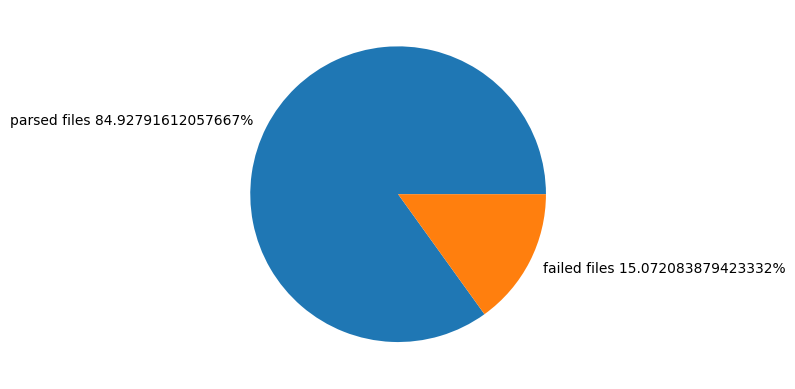

In [10]:
num_entries = len(database)
total_entries = len(files)
plt.pie([num_entries, total_entries - num_entries], labels=[f"parsed files {(num_entries/total_entries)*100}%", f"failed files {100 - (num_entries / total_entries)*100}%"])

In [11]:
num_entries, total_entries

(1296, 1526)

In [17]:
errors.plot_errors()

TypeError: bar() missing 1 required positional argument: 'height'

In [ ]:
database.close_db()